In [1]:
import pandas as pd
import numpy as np 
import os
import micom as mm
from plotnine import *
#import qiime2 as q2
from scipy import stats

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

### Load up the SCFA Measurements from the _ex vivo_ study

In [2]:
os.chdir("/proj/gibbons/nbohmann/exvivo/hamaker_2021/data/")
scfa = pd.read_csv("SCFA_forR_ correlation.csv")
scfa['Donor'] = scfa['Donor'].astype('str')
scfa['sample_id'] = scfa[['Treatment','Donor']].agg('_'.join, axis=1)
scfa = scfa.groupby(['sample_id','Treatment']).mean().reset_index().set_index('sample_id')
scfa['Acetate'] = scfa['Acetate']
scfa['Butyrate'] = scfa['Butyrate']
scfa['Propionate'] = scfa['Propionate']
scfa = scfa[(scfa.Treatment.str.contains('Blank'))|(scfa.Treatment.str.contains('Pectin'))]
scfa

,Treatment,Acetate,Propionate,Butyrate
sample_id,,,,
Blank_1,Blank,4.866667,1.113333,1.273333
Blank_10,Blank,3.913333,1.110000,0.733333
Blank_2,Blank,5.640000,1.270000,1.646667
Blank_3,Blank,3.663333,0.873333,0.783333
Blank_4,Blank,5.606667,1.790000,1.516667
Blank_5,Blank,5.260000,1.573333,1.766667
Blank_6,Blank,4.160000,1.020000,0.773333
Blank_7,Blank,4.120000,1.400000,0.946667
Blank_8,Blank,5.110000,1.423333,1.103333


#### Looks like there aren't SCFA measurements for the II treated samples. We'll remove those from the abundance tables.

### Let's load up the abundance table, format that, then build a taxonomy table too, for MICOM

In [3]:
os.chdir('/proj/gibbons/nbohmann/exvivo/hamaker_2021/data/')
abundance = pd.read_csv('hightha1perc_forR.csv') # Load the abundance
abundance['donor'] = abundance['donor'].astype('str')
abundance['sample_id'] = abundance[['treatment_II_B','donor']].agg('_'.join, axis=1) # Join the treatment and donor into sample ID
abundance = abundance.drop(columns = ['treatment_II_B','donor'])
abundance.set_index('sample_id',inplace = True)
abundance = abundance.sort_index() #sort the index in order
abundance = abundance[~abundance.index.str.contains('II_')] # Remove the treatment without SCFA measurements
abundance.reset_index(inplace = True)
for x in abundance.index[2:-2]: # Can't have duplicate IDs. This will add subscripts to all the triplicate samples 
    if abundance['sample_id'][x-1].startswith(abundance['sample_id'][x]) == False:
        abundance['sample_id'][x] = abundance['sample_id'][x] + '_I'
    elif abundance['sample_id'][x-2].startswith(abundance['sample_id'][x]) == False:
            abundance['sample_id'][x] = abundance['sample_id'][x] + '_II'
    else: abundance['sample_id'][x] = abundance['sample_id'][x] + '_III'
abundance['sample_id'][0] = abundance['sample_id'][0] + '_I' # gotta do a couple by hand bc of edge cases
abundance['sample_id'][1] = abundance['sample_id'][1] + '_II'
abundance['sample_id'][146] = abundance['sample_id'][146] + '_II'
abundance['sample_id'][147] = abundance['sample_id'][147] + '_III'
# abundance.set_index('sample',inplace = True)
abundance

,sample_id,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__uniformis,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium;s__prausnitzii,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium;__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Roseburia;s__faecis,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__acidifaciens,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;__;__,...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnospira;s__,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Parabacteroides;s__distasonis,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__plebeius,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;__;__,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Parabacteroides;s__,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia;s__muciniphila,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Succinivibrionaceae;g__Succinivibrio;s__
0,Blank_1_I,13.884336,3.512058,1.720908,3.394989,3.828143,2.833060,7.305081,0.479981,1.053617,...,2.025287,0.000000,12.081480,0.796066,0.199017,0.000000,2.528682,1.720908,1.182393,0.0
1,Blank_1_II,14.089150,3.425541,1.863265,3.353877,4.228178,2.737566,7.166404,0.401319,1.304286,...,1.891931,0.000000,12.827863,0.888634,0.100330,0.000000,2.694568,1.777268,1.232621,0.0
2,Blank_1_III,13.735558,3.477652,1.820516,3.676042,3.886101,2.649084,7.247053,0.303419,1.272027,...,2.077255,0.000000,11.611623,0.933598,0.151710,0.000000,2.322325,1.937216,1.248687,0.0
3,Blank_10_I,25.272512,7.156398,4.099526,4.952607,3.554502,0.000000,7.867299,4.194313,0.438389,...,0.000000,2.168246,0.000000,0.450237,0.000000,3.838863,0.059242,0.142180,0.000000,0.0
4,Blank_10_II,26.925986,7.358185,4.213938,4.851432,3.987034,0.000000,5.294435,5.013506,0.432199,...,0.000000,1.663965,0.000000,0.280929,0.000000,4.959481,0.000000,0.075635,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,RS_8_II,8.135671,3.093847,1.352126,4.468890,5.293915,2.154234,0.148963,1.111493,2.612582,...,0.412513,6.806463,0.000000,3.151140,0.022917,0.148963,1.546923,1.122952,2.268821,0.0
144,RS_8_III,8.711839,2.419955,1.054852,3.809878,4.939191,2.444775,0.235791,1.030032,2.196575,...,0.359891,7.669397,0.000000,2.643336,0.037230,0.111690,1.327873,2.047655,2.357905,0.0
145,RS_9_I,8.889133,7.361828,10.647182,5.922426,0.000000,2.933744,0.000000,0.846061,0.879024,...,0.230744,2.856829,2.087683,1.329524,0.000000,4.636853,2.197561,2.472256,3.384243,0.0
146,RS_9_II,10.122164,9.822987,10.334081,4.923959,0.000000,3.615059,0.000000,1.159312,1.221640,...,0.373972,2.692595,2.443281,1.358763,0.000000,3.290950,1.819995,1.857392,3.103964,0.0


In [4]:
abundance = pd.melt(abundance, id_vars = 'sample_id', value_vars = abundance.columns[1:], var_name = 'id', value_name = 'abundance')
abundance['id'] = (abundance['id'].str.replace('k__','').str.replace('p__','').
                   str.replace('c__','').str.replace('o__','').str.replace('f__','').
                   str.replace('g__','').str.replace('s__',''))
abundance['genus'] = abundance['id'].str.split(';').str[-2]
abundance

,sample_id,id,abundance,genus
0,Blank_1_I,Bacteria;Bacteroidetes;Bacteroidia;Bacteroidal...,13.884336,Bacteroides
1,Blank_1_II,Bacteria;Bacteroidetes;Bacteroidia;Bacteroidal...,14.089150,Bacteroides
2,Blank_1_III,Bacteria;Bacteroidetes;Bacteroidia;Bacteroidal...,13.735558,Bacteroides
3,Blank_10_I,Bacteria;Bacteroidetes;Bacteroidia;Bacteroidal...,25.272512,Bacteroides
4,Blank_10_II,Bacteria;Bacteroidetes;Bacteroidia;Bacteroidal...,26.925986,Bacteroides
...,...,...,...,...
3843,RS_8_II,Bacteria;Proteobacteria;Gammaproteobacteria;Ae...,0.000000,Succinivibrio
3844,RS_8_III,Bacteria;Proteobacteria;Gammaproteobacteria;Ae...,0.000000,Succinivibrio
3845,RS_9_I,Bacteria;Proteobacteria;Gammaproteobacteria;Ae...,0.000000,Succinivibrio
3846,RS_9_II,Bacteria;Proteobacteria;Gammaproteobacteria;Ae...,0.000000,Succinivibrio


In [5]:
agora = ('/proj/gibbons/refs/micom_dbs/agora103_genus.qza')
agora

'/proj/gibbons/refs/micom_dbs/agora103_genus.qza'

In [6]:
models = mm.workflows.build(abundance,out_folder = '/proj/gibbons/nbohmann/exvivo/hamaker_2021/micom/models/',
                      model_db = agora, cutoff = 0.001, threads = 20)

[12:55:49] WARNING  Found existing models for 140 samples. Will skip those.       ]8;id=409832;file:///users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/micom/workflows/build.py\build.py]8;;\:]8;id=144011;file:///users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/micom/workflows/build.py#95\95]8;;\
                    Delete the output folder if you would like me to rebuild                 
                    them.                                                                    

Output()

In [ ]:
taxa = abundance.columns.to_frame() #make a taxa 
taxa = taxa[0].str.split(';',expand = True)
for x in taxa.columns:
    taxa[x] = taxa[x].str[3:]
taxa.drop(columns = [6],inplace = True)
taxa = taxa.rename(columns = {0:'Kingdom',1:'Phylum',2:'Class',3:'Order',4:'Family',5:'Genus'})
taxa['Feature ID'] = taxa.apply(lambda row: ".".join(row.fillna("").str.lower()), axis=1).to_frame()
taxa.set_index('Feature ID',inplace = True)
taxa = taxa.apply(lambda row: ";".join(row.str.capitalize().fillna("")), axis=1).to_frame()
taxa = taxa.rename(columns = {0:'Taxon'})
abundance.columns = taxa.index
abundance = abundance.groupby(axis=1, level=0).sum()
taxa = taxa.drop_duplicates()

In [6]:
os.chdir('/proj/gibbons/nbohmann/exvivo/hamaker_2021')
abundance.to_csv('abundance.csv')
abundance.to_csv('taxa.csv')
abundance_artifact = q2.Artifact.import_data("FeatureTable[Frequency]", abundance)
abundance_artifact.save("abundance.qza")
taxa_artifact = q2.Artifact.import_data("FeatureData[Taxonomy]", taxa)
taxa_artifact.save("taxa.qza")

NameError: name 'q2' is not defined

### Build the Models

In [6]:
os.chdir('/proj/gibbons/nbohmann/exvivo/')

In [7]:
%%bash
qiime micom build --i-abundance hamaker_2021/abundance.qza \
                  --i-taxonomy hamaker_2021/taxa.qza \
                  --i-models tables/agora103_genus.qza \
                  --p-cutoff 0.001 \
                  --p-threads 12 \
                  --o-community-models models.qza \
                  --verbose

Usage: qiime micom build [OPTIONS]

  Builds the metabolic community models for a set of samples.

Inputs:
  --i-abundance ARTIFACT FeatureTable[Frequency | RelativeFrequency]
                          The feature table containing the samples over which
                          beta diversity should be computed.        [required]
  --i-taxonomy ARTIFACT FeatureData[Taxonomy]
                          The taxonomy assignments for the ASVs in the table.
                                                                    [required]
  --i-models ARTIFACT MetabolicModels[JSON]
                          The single taxon model database to use.   [required]
Parameters:
  --p-threads INTEGER     The number of threads to use when constructing
    Range(1, None)        models.                                 [default: 1]
  --p-cutoff PROPORTION   Taxa with a relative abundance smaller than this
    Range(0.0, 1.0)       will be dropped.                   [default: 0.0001]
  --p-strict / --p-no-s

CalledProcessError: Command 'b'qiime micom build --i-abundance hamaker_2021/abundance.qza \\\n                  --i-taxonomy hamaker_2021/taxa.qza \\\n                  --i-models tables/agora103_genus.qza \\\n                  --p-cutoff 0.001 \\\n                  --p-threads 12 \\\n                  --o-community-models models.qza \\\n                  --verbose\n'' returned non-zero exit status 1.

### Grow the Models

In [2]:
os.chdir('/proj/gibbons/nbohmann/exvivo/hamaker_2021/micom/')
manifest = pd.read_csv('models/manifest.csv')
# tradeoff = mm.workflows.tradeoff(manifest, model_folder='models',medium = medium, 
#                                 tradeoffs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
#                                  presolve = True, threads = 5)

In [4]:
manifest.found_taxa.describe()

count    148.000000
mean      16.290541
std        2.703622
min       10.000000
25%       15.000000
50%       17.000000
75%       18.000000
max       21.000000
Name: found_taxa, dtype: float64

In [11]:
os.chdir('/proj/gibbons/nbohmann/exvivo/')
medium = pd.read_csv('minimal_media.csv')
os.chdir("/proj/gibbons/nbohmann/exvivo/hamaker_2021/micom/")
manifest = pd.read_csv('models/manifest.csv')
manifest = manifest[manifest.sample_id.str.startswith('Blank')]
growth = mm.workflows.grow(manifest,'models',medium=medium,tradeoff=.5,strategy='none',threads = 5)
fluxes = growth.exchanges
fluxes = fluxes[fluxes.direction == "export"].groupby(["sample_id", "metabolite", "reaction"]).apply(lambda df: sum(df.flux * df.abundance)).reset_index()
os.chdir('/proj/gibbons/nbohmann/exvivo/hamaker_2021/data/')
fluxes.to_csv('ctrl_flux.csv') 

Output()

/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/micom/workflows/grow.py:199: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [10]:
os.chdir('/proj/gibbons/nbohmann/exvivo/')
medium = pd.read_csv('minimal_media.csv')
os.chdir("/proj/gibbons/nbohmann/exvivo/hamaker_2021/micom/")
manifest = pd.read_csv('models/manifest.csv')
manifest = manifest[manifest.sample_id.str.startswith('Pect')]
treatment_medium = medium.append({'reaction':'EX_pect_m','flux':10.00000},ignore_index=True)
growth = mm.workflows.grow(manifest,'models',medium=treatment_medium,tradeoff=.5,strategy='none',threads = 20)
fluxes = growth.exchanges
fluxes = fluxes[fluxes.direction == "export"].groupby(["sample_id", "metabolite", "reaction"]).apply(lambda df: sum(df.flux * df.abundance)).reset_index()
os.chdir('/proj/gibbons/nbohmann/exvivo/hamaker_2021/data/')
fluxes.to_csv('pect_fluxes.csv')

/tmp/ipykernel_2245437/3199958963.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Output()

/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/micom/workflows/grow.py:199: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


### Now we'll extract the predicted flux from MICOM, and compare with experimental SCFA measurements

In [12]:
def find_scfas(df,treatment):
    #narrow down to scfas of interest
    new_df = df[(df.reaction.str.startswith("EX_but(e)"))|(df.reaction.str.startswith("EX_ac(e)"))|
                        (df.reaction.str.startswith("EX_ppa(e)"))].reset_index(drop = True)
    #rename columns for clarity
    new_df = new_df.rename(columns = {'0':'flux'})
    #here, put the data in a pivot table. this makes manipulating it eaiser
    new_df = pd.pivot_table(new_df, index = 'sample_id', columns = 'metabolite', values = 'flux')
    #add a treatment column so we can append the tables together
    new_df['treatment'] = treatment
    #reset the index so we don't lose the sample ids when appending
    new_df.reset_index(inplace=True)
    return new_df

In [13]:
os.chdir("/proj/gibbons/nbohmann/exvivo/hamaker_2021/data/")
ctrl = pd.read_csv('ctrl_flux.csv',index_col = 0)
pect = pd.read_csv('pect_fluxes.csv',index_col = 0)
micom = find_scfas(ctrl,'Blank')
micom = micom.append(find_scfas(pect,'Pectin'),ignore_index=True)
micom['sample_id'] = micom['sample_id'].str.split('_').str[1]
micom = micom.groupby(['sample_id','treatment']).mean().reset_index()
micom['sample'] = micom['treatment']+'_'+micom['sample_id']
micom = micom.set_index('sample').drop(columns = {'sample_id','treatment'})
ac_micom = micom['ac[e]'].to_dict()
but_micom = micom['but[e]'].to_dict()
ppa_micom = micom['ppa[e]'].to_dict()

/tmp/ipykernel_2245437/1200233260.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [14]:
scfa['Acetate - Predicted'] = scfa.index.map(ac_micom)
scfa['Butyrate - Predicted'] = scfa.index.map(but_micom)
scfa['Propionate - Predicted'] = scfa.index.map(ppa_micom)
scfa['Treatment'][scfa[scfa['Treatment'].str.contains('Blank')].index] = 'Control'

In [15]:
scfa

,Treatment,Acetate,Propionate,Butyrate,Acetate - Predicted,Butyrate - Predicted,Propionate - Predicted
sample_id,,,,,,,
Blank_1,Control,4.866667,1.113333,1.273333,44.092109,13.020117,0.434395
Blank_10,Control,3.913333,1.110000,0.733333,51.753003,6.974386,0.491100
Blank_2,Control,5.640000,1.270000,1.646667,38.735028,14.674551,0.412121
Blank_3,Control,3.663333,0.873333,0.783333,51.702153,22.428667,0.364913
Blank_4,Control,5.606667,1.790000,1.516667,31.978565,19.086912,0.432018
Blank_5,Control,5.260000,1.573333,1.766667,48.965221,11.517014,0.444356
Blank_6,Control,4.160000,1.020000,0.773333,26.306376,17.084178,0.468925
Blank_7,Control,4.120000,1.400000,0.946667,55.827146,11.305407,0.365354
Blank_8,Control,5.110000,1.423333,1.103333,34.471198,12.906616,0.442343


### Now we'll plot the measured and predicted fluxes against each other and examine the correlation

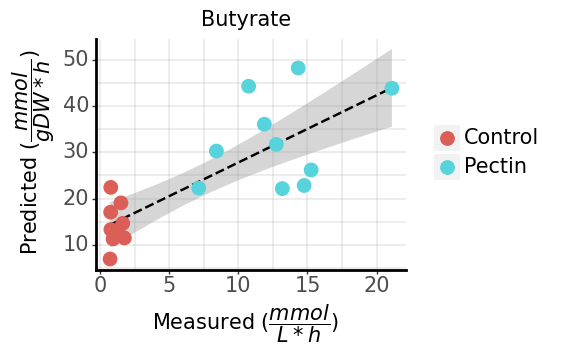

<ggplot: (8729926163872)>

In [16]:
plt=(
    ggplot(
        scfa, aes(x ='Butyrate',y = 'Butyrate - Predicted'))
        +geom_smooth(method='lm',linetype='--')
        +geom_point(aes(color = 'Treatment'),size=5)
        +labs(x='Measured ($\dfrac{mmol}{L*h}$)',y='Predicted ($\dfrac{mmol}{gDW*h}$)',title = 'Butyrate')
        +theme(text = element_text(size=15),panel_background=element_rect(fill = "white",
                                colour = "white",size = 0.5, linetype = "solid"),
                                panel_grid=element_line(size = .2, linetype = "solid",colour = "gray"),
                                axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                legend_title=element_blank(),
                                legend_position='right',figure_size = (4,3)))

plt

In [21]:
os.chdir('/users/nbohmann/ex_vivo/hamaker_scfas/')
ggsave(plt,"but.png", width = 4, height = 3)

/users/nbohmann/miniconda3/envs/qiime2-2021/lib/python3.6/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 4 x 3 in image.
/users/nbohmann/miniconda3/envs/qiime2-2021/lib/python3.6/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: but.png


In [61]:
scfa

rho, pval = stats.pearsonr(scfa[(scfa.Treatment.str.contains('Pectin'))]['Butyrate'],scfa[((scfa.Treatment.str.contains('Pectin')))]['Butyrate - Predicted'])
print('Treatment Group Correlation: ',rho.round(3))
print('P-value: ',pval.round(3))

Treatment Group Correlation:  0.364
P-value:  0.302


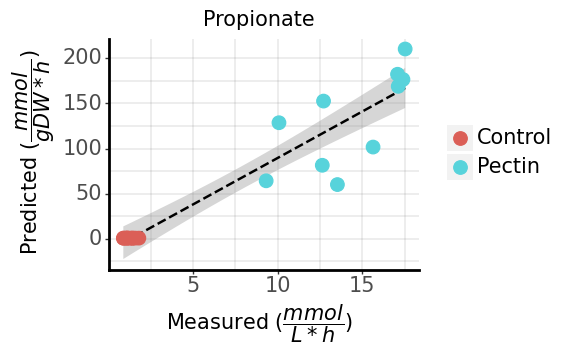

<ggplot: (8729926103622)>

In [17]:
plt=(
    ggplot(
        scfa, aes(x ='Propionate',y = 'Propionate - Predicted'))
        +geom_smooth(method='lm',linetype='--')
        +geom_point(aes(color = 'Treatment'),size=5)
        +labs(x='Measured ($\dfrac{mmol}{L*h}$)',y='Predicted ($\dfrac{mmol}{gDW*h}$)',title = 'Propionate')
        +theme(text = element_text(size=15),panel_background=element_rect(fill = "white",
                                colour = "white",size = 0.5, linetype = "solid"),
                                panel_grid=element_line(size = .2, linetype = "solid",colour = "gray"),
                                axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                legend_title=element_blank(),
                                legend_position='right',figure_size = (4,3)))

plt

In [19]:
os.chdir('/users/nbohmann/ex_vivo/hamaker_scfas/')
ggsave(plt,"ppa.png", width = 4, height = 3)

/users/nbohmann/miniconda3/envs/qiime2-2021/lib/python3.6/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 4 x 3 in image.
/users/nbohmann/miniconda3/envs/qiime2-2021/lib/python3.6/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ppa.png


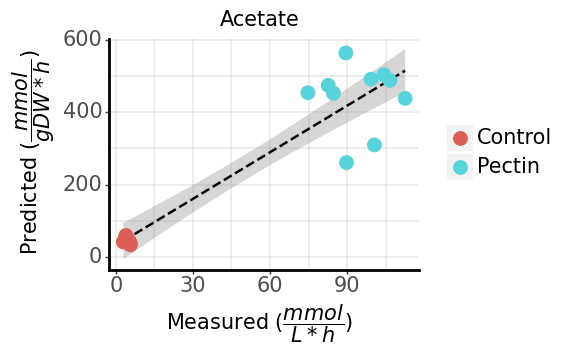

<ggplot: (8769528832569)>

In [22]:
plt=(
    ggplot(
        scfa, aes(x ='Acetate',y = 'Acetate - Predicted'))
        +geom_smooth(method='lm',linetype='--')
        +geom_point(aes(color = 'Treatment'),size=5)
        +labs(x='Measured ($\dfrac{mmol}{L*h}$)',y='Predicted ($\dfrac{mmol}{gDW*h}$)',title = 'Acetate')
        +theme(text = element_text(size=15),panel_background=element_rect(fill = "white",
                                colour = "white",size = 0.5, linetype = "solid"),
                                panel_grid=element_line(size = .2, linetype = "solid",colour = "gray"),
                                axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                legend_title=element_blank(),
                                legend_position='right',figure_size = (4,3)))

plt